# Read a Graph

### Data is the currency of science, but it is packaged in figures

Can we unpackage data and re-use it?

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import IPython
import scipy.ndimage as ndimage
# try:
#     import Image
# except ImportError:
from PIL import Image
import pytesseract as tes

import sys
sys.path.insert(0, './functions')
import ocr_tools
import find_axes
from thresholding import adaptive_thresh

print('All packages loaded')

All packages loaded


<IPython.core.display.Javascript object>


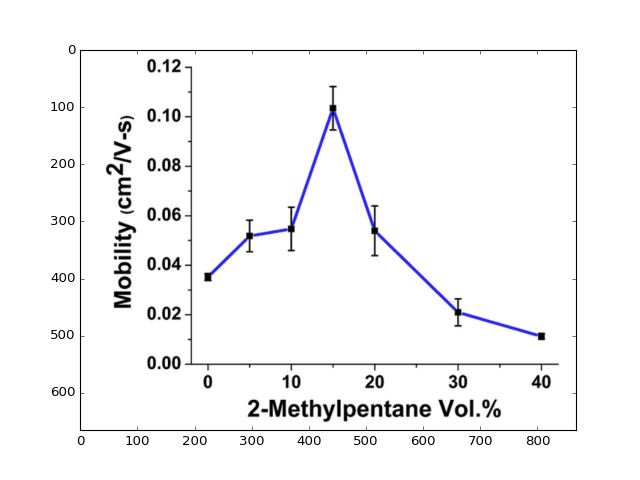

In [2]:
example = 'examples/Example-Mobility.png'
img = cv2.imread(example)
m,n,p=img.shape

%matplotlib notebook
implot = plt.imshow(img)

## This is our starting point

We would like to find the axes, calibrate them from pixel to data space, find the data and extract it.

<IPython.core.display.Javascript object>


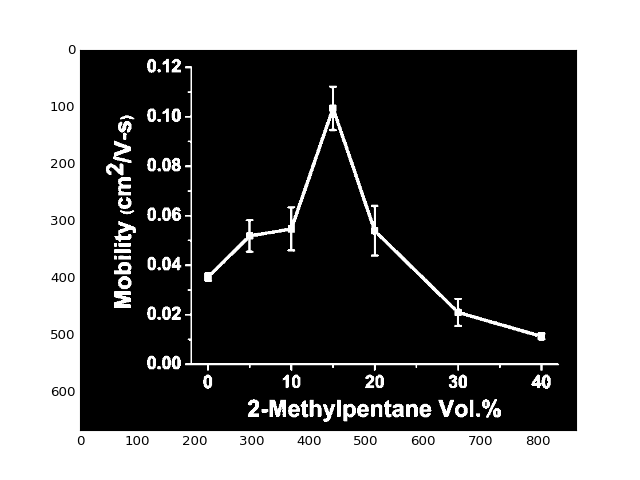

In [3]:
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
bw4 = adaptive_thresh(gray)
nbw = (255-bw4)

%matplotlib notebook
implot = plt.imshow(nbw, cmap='gray')

### Every image processing workflow starts with a threshold

Many features are available from the black and white image. We will start with a simple one: lines. These are extracted through a Hough Transform

In [4]:
linesP = cv2.HoughLinesP(nbw,1,np.pi/2,2, minLineLength = nbw.shape[1]/10, maxLineGap = 3)[0]
print('Hough Transform complete')
print(linesP[0:4])

Hough Transform complete
[[194 552 194  30]
 [193 552 193  30]
 [516 362 516 272]
 [195 552 195  31]]


## So we've got some line segments.

Now we are going to engineer an axis feature score, for example, the x-axis:

[cos^2, fractional length, fractional y-coord (or x coord for y axis)]

"How horizontal is this line segment?"
"How long is it relative to the image size?"
"Where is it in the image?"

In [5]:
import find_axes
# print(linesP)
xax = find_axes.get_xaxis(linesP,nbw)
print('x axis')
print(xax)
yax = find_axes.get_yaxis(linesP,nbw)
print('y axis')
print(yax)

x axis
[184 549 834 549]
y axis
[195 552 195  31]


## Let's draw the results

<IPython.core.display.Javascript object>


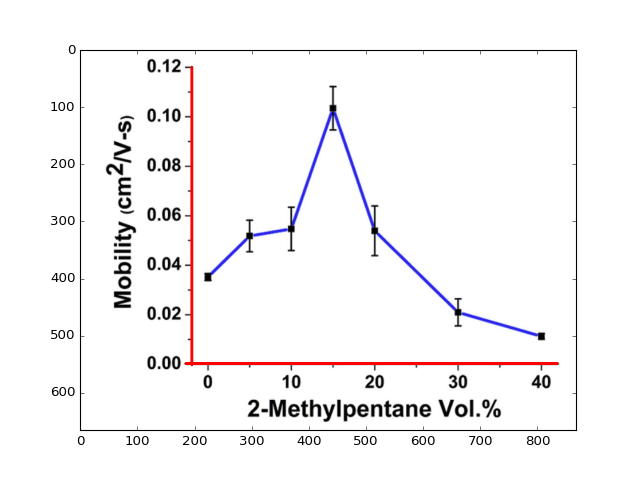

In [6]:
imlabel = img.copy();
cv2.line(imlabel,(xax[0],xax[1]),(xax[2],xax[3]),(255,0,0),4)
cv2.line(imlabel,(yax[0],yax[1]),(yax[2],yax[3]),(255,0,0),4)

%matplotlib notebook
implot = plt.imshow(imlabel)
implot.set_cmap('gray')

## Now let's find ticks and tick labels

It's actually easier to start by finding the labels - in fact, in many cases it's not necessary to even find the ticks at all.

OCR is difficult. Pytesseract is the best open source library for it, but it's not a panacea. We can help it by first isolating the region from which we'd like to extract text.

<IPython.core.display.Javascript object>


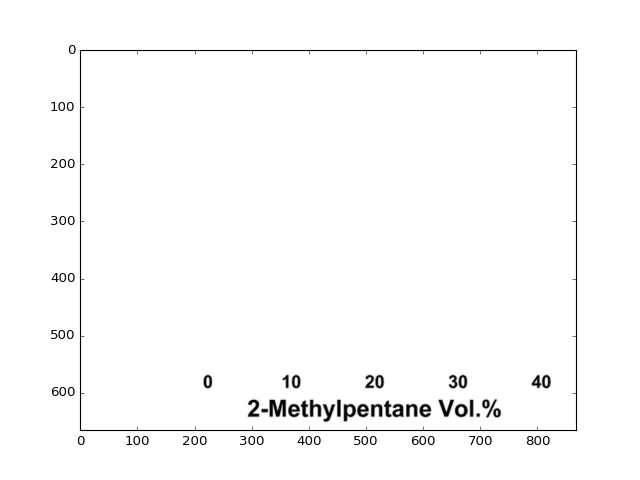

In [7]:
%matplotlib notebook

# Find where the x-ticks stop and crop the text image to be below that
below_xax_bw = np.zeros([m,n]).astype('uint8')
below_xax_bw[xax[1]:,:]=nbw[xax[1]:,:]
row_sums = below_xax_bw.sum(axis=1)
row_sums[0:xax[1]] = 1000
row_sums_list = row_sums.tolist()
text_crop_ind = row_sums_list.index(0)
text_crop_ind

xTextImg = np.ones([m,n,p]).astype('uint8')*255
xTextImg[text_crop_ind+1:,:,:]=img[text_crop_ind+1:,:,:]

cv2.imwrite('temp/xtext.png',xTextImg)
implot = plt.imshow(xTextImg)


In [9]:
xocr = tes.image_to_string(Image.open('temp/xtext.png'),boxes=True)
print('OCR complete')

OCR complete


In [10]:
import ocr_tools

words = ocr_tools.clean_ocr_results(xocr)
words

[['0', 216, 73, 231, 96],
 ['1o', 354, 73, 385, 96],
 ['20', 498, 73, 531, 96],
 ['30', 644, 73, 676, 96],
 ['2-Methylpentane', 293, 14, 613, 53],
 ['Vo|.', 626, 22, 699, 53],
 ['\xc2\xb0', 702, 37, 716, 53],
 ['k', 708, 22, 735, 54],
 ['40', 789, 73, 822, 96]]

### We're looking for numbers

Let's pick those out.

In [11]:
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

numbers = [w for w in words if is_number(w[0])]
for w in numbers:
    w[0]=float(w[0])
    w[2] = m-w[2]
    w[4] = m-w[4]
    w.append((w[1]+w[3])/2)
    w.append((w[2]+w[4])/2)
    
xt_labels = np.array(numbers)

<IPython.core.display.Javascript object>


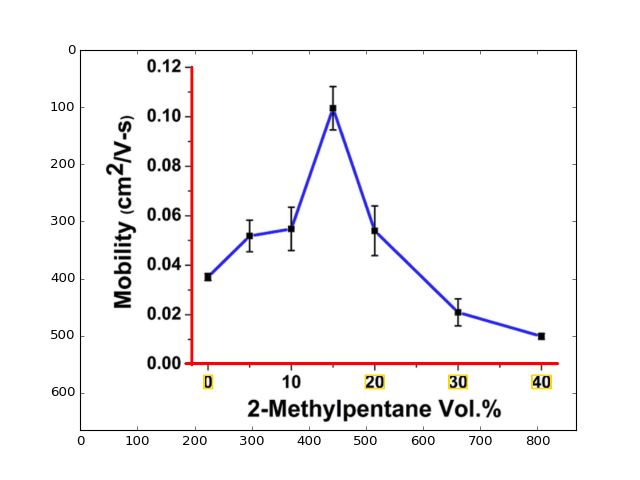

In [12]:
%matplotlib notebook

for w in numbers:
    cv2.rectangle(imlabel, (w[1],w[2]), (w[3],w[4]), (255,215,0), thickness=2, lineType=8, shift=0)

implot = plt.imshow(imlabel)

# Find X Ticks


### This is going to match tick labels with their nearest vertical line segment on the x-axis.

In [13]:
xt_dirty = find_axes.get_xticks(nbw,xax,tickMargin=11,minTickLen=0,maxGap=0)
xt_list=xt_dirty.tolist()

In [14]:
xt_match = find_axes.match_xticks(numbers,xt_list)
xt_pts = [xt_list[i] for i in xt_match]
xt_pts

[[223, 559, 223, 549],
 [514, 559, 514, 549],
 [660, 559, 660, 549],
 [805, 559, 805, 549]]

<IPython.core.display.Javascript object>


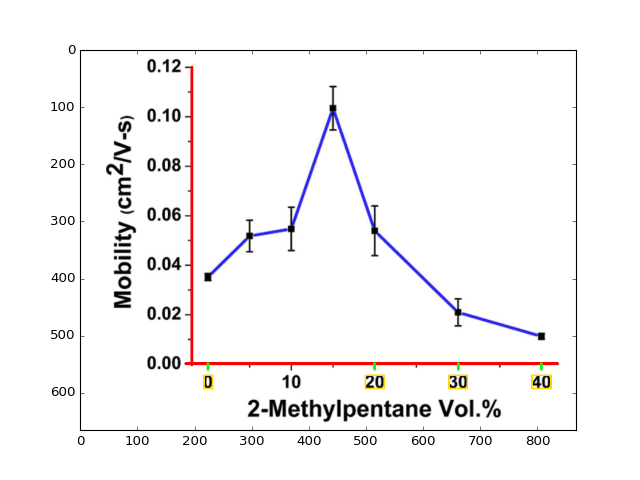

In [15]:
%matplotlib notebook
for x1,y1,x2,y2 in xt_pts:
    cv2.line(imlabel,(x1,y1),(x2,y2),(0,255,0),4)

implot = plt.imshow(imlabel)

In [19]:
xt_pts_array = np.array(xt_pts)
xt_pts_array[:,0].reshape(-1,1)

print('X Axis in pixels')
print(xt_pts_array[:,0].reshape(-1,1))

X Axis in pixels
[[223]
 [514]
 [660]
 [805]]


In [20]:
xt_labels[:,0].reshape(-1,1)
print('X Axis in Data')
print(xt_labels[:,0].reshape(-1,1))

X Axis in Data
[[  0.]
 [ 20.]
 [ 30.]
 [ 40.]]


## Convert x-axis from pixel space to data space with regression

We have a sort of calibration curve between pixel space and data space.

In [21]:
# %matplotlib notebook
# hcalib = plt.plot(xt_pts_array[:,0].reshape(-1,1), xt_labels[:,0].reshape(-1,1))
# plt.xlabel('pixels')
# plt.ylabel('x-axis data')

In [22]:
from sklearn import datasets, linear_model
regrx = linear_model.LinearRegression(fit_intercept=True)

regrx.fit(xt_pts_array[:,0].reshape(-1,1), xt_labels[:,0].reshape(-1,1))

# The coefficients
print 'Coefficients: \n', regrx.coef_
print 'Intercept: \n', regrx.intercept_

Coefficients: 
[[ 0.06870822]]
Intercept: 
[-15.3238755]


## Now Get Y Ticks

In [23]:
# Find where the y-ticks stop and crop the text image to be left of that
left_yax_bw = np.zeros([m,n]).astype('uint8')
left_yax_bw[:yax[0],:]=nbw[:yax[0],:]
col_sums = left_yax_bw.sum(axis=0)
col_sums[yax[0]:] = 1000
col_zeros=np.where(col_sums==0)[0]
y_crop_ind=col_zeros[-1]
print('cropping y-axis region')

cropping y-axis region


<IPython.core.display.Javascript object>


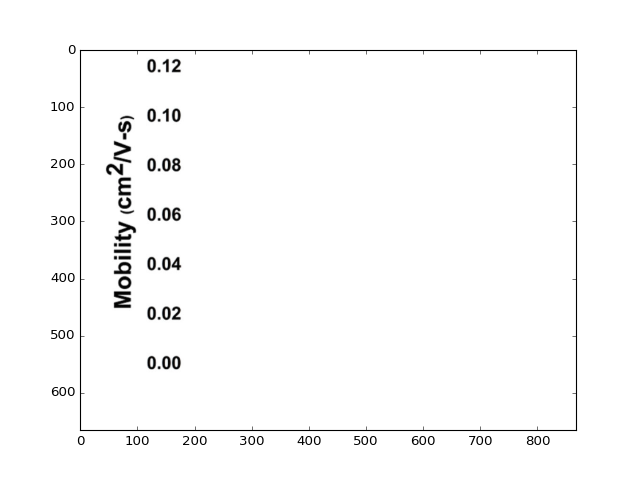

//anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/comm/comm.py:52: DeprecationWarning: Comm._comm_id_default is deprecated: use @default decorator instead.
  def _comm_id_default(self):
//anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/comm/comm.py:29: DeprecationWarning: Comm._iopub_socket_default is deprecated: use @default decorator instead.
  def _iopub_socket_default(self):
//anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/comm/comm.py:24: DeprecationWarning: Comm._kernel_default is deprecated: use @default decorator instead.
  def _kernel_default(self):
//anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/comm/comm.py:32: DeprecationWarning: Comm._session_default is deprecated: use @default decorator instead.
  def _session_default(self):
//anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/comm/comm.py:41: DeprecationWarning: Comm._topic_default is deprecated: use @default decorator instead.
  def _topic_default(self):
//anaconda/envs/py27/

In [24]:
%matplotlib notebook
yTextImg = np.ones([m,n,p]).astype('uint8')*255
yTextImg[:,0:y_crop_ind-1,:]=img[:,0:y_crop_ind-1,:]

cv2.imwrite('temp/ytext.png',yTextImg)
implot = plt.imshow(yTextImg)

## Unfortunately

For OCR to work effectively on the y-axis, we must remove the rotated axis title completely. This is quite challenging.

<IPython.core.display.Javascript object>


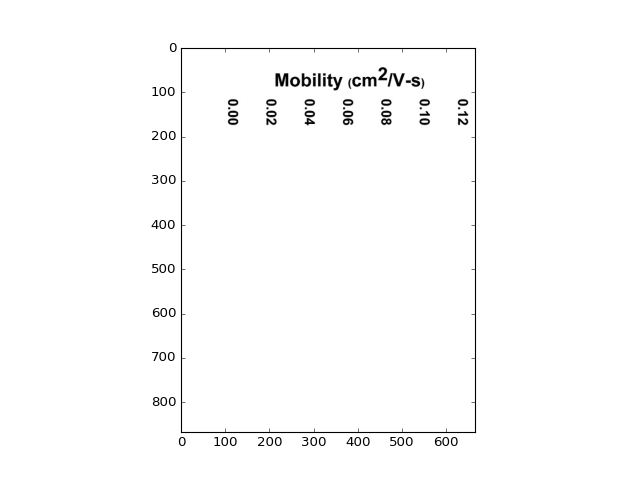

//anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/comm/comm.py:52: DeprecationWarning: Comm._comm_id_default is deprecated: use @default decorator instead.
  def _comm_id_default(self):
//anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/comm/comm.py:29: DeprecationWarning: Comm._iopub_socket_default is deprecated: use @default decorator instead.
  def _iopub_socket_default(self):
//anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/comm/comm.py:24: DeprecationWarning: Comm._kernel_default is deprecated: use @default decorator instead.
  def _kernel_default(self):
//anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/comm/comm.py:32: DeprecationWarning: Comm._session_default is deprecated: use @default decorator instead.
  def _session_default(self):
//anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/comm/comm.py:41: DeprecationWarning: Comm._topic_default is deprecated: use @default decorator instead.
  def _topic_default(self):
//anaconda/envs/py27/

In [25]:
%matplotlib notebook

yTextRot = ndimage.interpolation.rotate(yTextImg, -90)
cv2.imwrite('temp/ytextrot.png',yTextRot)
implot = plt.imshow(yTextRot)
implot.set_cmap('gray')

In [26]:
yRotOcr = tes.image_to_string(Image.open('temp/ytextrot.png'),boxes=True)
print(yRotOcr)

0 106 692 129 707 0
0 106 709 129 725 0
' 106 727 111 732 0
0 106 735 129 750 0
M 213 779 242 809 0
o 246 778 269 801 0
b 273 778 294 809 0
i 298 779 304 809 0
l 309 779 315 809 0
i 321 779 327 809 0
t 330 778 343 807 0
y 343 770 365 801 0
( 378 774 384 798 0
c 387 778 407 801 0
m 410 779 441 801 0
Z 445 793 465 822 0
N 467 778 505 809 0
- 508 787 519 793 0
S 520 778 540 801 0
) 543 774 549 798 0
P 192 727 216 750 0
P 279 727 302 750 0
P 365 727 389 750 0
P 452 727 475 750 0
P 538 727 562 750 0
O 192 709 216 725 0
O 279 709 302 725 0
O 366 710 389 725 0
O 452 709 475 725 0
A 539 713 562 723 0
N 193 692 216 708 0
h 280 691 302 708 0
Q 365 692 389 707 0
a 452 692 475 707 0
O 538 692 562 707 0
9 625 727 648 750 0
a 625 713 648 723 0
N 625 692 648 708 0


### Find the longest "word" and clear its bounding box

In [27]:
yrot_words = ocr_tools.clean_ocr_results(yRotOcr,charspace=15,neg_charspace=-3)
word_length = [len(i[0]) for i in yrot_words]
longest_word = np.array(word_length).argmax()
lwbox = yrot_words[longest_word]
lwbox

['Mobility(cmZN-S)', 213, 770, 549, 822]

<IPython.core.display.Javascript object>


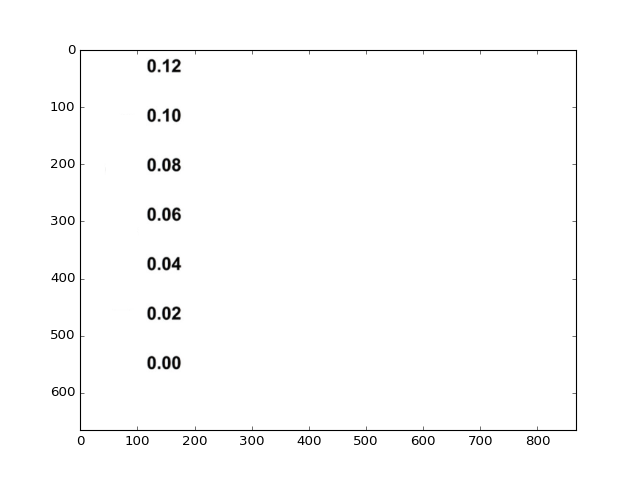

//anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/comm/comm.py:52: DeprecationWarning: Comm._comm_id_default is deprecated: use @default decorator instead.
  def _comm_id_default(self):
//anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/comm/comm.py:29: DeprecationWarning: Comm._iopub_socket_default is deprecated: use @default decorator instead.
  def _iopub_socket_default(self):
//anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/comm/comm.py:24: DeprecationWarning: Comm._kernel_default is deprecated: use @default decorator instead.
  def _kernel_default(self):
//anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/comm/comm.py:32: DeprecationWarning: Comm._session_default is deprecated: use @default decorator instead.
  def _session_default(self):
//anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/comm/comm.py:41: DeprecationWarning: Comm._topic_default is deprecated: use @default decorator instead.
  def _topic_default(self):
//anaconda/envs/py27/

In [28]:
x1 = lwbox[1]-1
y1 = lwbox[2]-1
x2 = lwbox[3]+1
y2 = lwbox[4]+1
y1 = n-y1
y2 = n-y2
yTextRot[y2:y1+1,x1:x2+1,:] = np.ones([y1-y2+1,x2-x1+1,3]).astype('uint8')*255
yText_Clean = ndimage.interpolation.rotate(yTextRot, 90)

%matplotlib notebook
implot = plt.imshow(yText_Clean)

### Conventional OCR

In [29]:
cv2.imwrite('temp/ytextclean.png',yText_Clean)
yocr = tes.image_to_string(Image.open('temp/ytextclean.png'),boxes=True)
yl_ocr = ocr_tools.clean_ocr_results(yocr)
yl_ocr

[['0.12', 118, 625, 176, 648],
 ['0.10', 118, 538, 176, 562],
 ['0.08', 118, 452, 176, 475],
 ['0.06', 118, 365, 176, 389],
 ['0.04', 118, 279, 177, 302],
 ['0.02', 118, 192, 176, 216],
 ['0.00', 118, 106, 176, 129]]

In [30]:
yt_numbers = [w for w in yl_ocr if is_number(w[0])]
for w in yt_numbers:
    w[0]=float(w[0])
    w[2] = m-w[2]
    w[4] = m-w[4]
    w.append((w[1]+w[3])/2)
    w.append((w[2]+w[4])/2)
    
yt_label_array = np.array(yt_numbers)

<IPython.core.display.Javascript object>


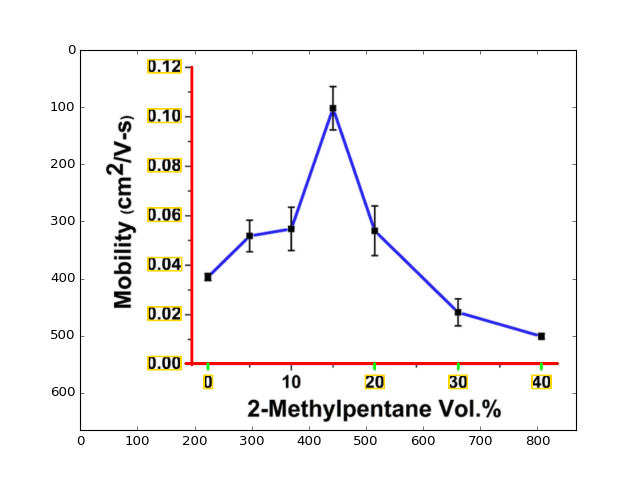

//anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/comm/comm.py:52: DeprecationWarning: Comm._comm_id_default is deprecated: use @default decorator instead.
  def _comm_id_default(self):
//anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/comm/comm.py:29: DeprecationWarning: Comm._iopub_socket_default is deprecated: use @default decorator instead.
  def _iopub_socket_default(self):
//anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/comm/comm.py:24: DeprecationWarning: Comm._kernel_default is deprecated: use @default decorator instead.
  def _kernel_default(self):
//anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/comm/comm.py:32: DeprecationWarning: Comm._session_default is deprecated: use @default decorator instead.
  def _session_default(self):
//anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/comm/comm.py:41: DeprecationWarning: Comm._topic_default is deprecated: use @default decorator instead.
  def _topic_default(self):
//anaconda/envs/py27/

In [31]:
%matplotlib notebook

for w in yt_numbers:
    cv2.rectangle(imlabel, (w[1],w[2]), (w[3],w[4]), (255,215,0), thickness=2, lineType=8, shift=0)

implot = plt.imshow(imlabel)

## Now run the same label/tick matching algorithm for the y-axis

In [32]:
yt_dirty = find_axes.get_yticks(nbw,yax,tickMargin=11,minTickLen=0,maxGap=2)
yt_list=yt_dirty.tolist()
yt_match = find_axes.match_xticks(yt_numbers,yt_list)
yt_pts = [yt_list[i] for i in yt_match]
yt_pts

[[184, 31, 194, 31],
 [184, 118, 195, 118],
 [184, 204, 195, 204],
 [184, 291, 195, 291],
 [184, 377, 195, 377],
 [184, 464, 195, 464],
 [184, 550, 205, 550]]

<IPython.core.display.Javascript object>


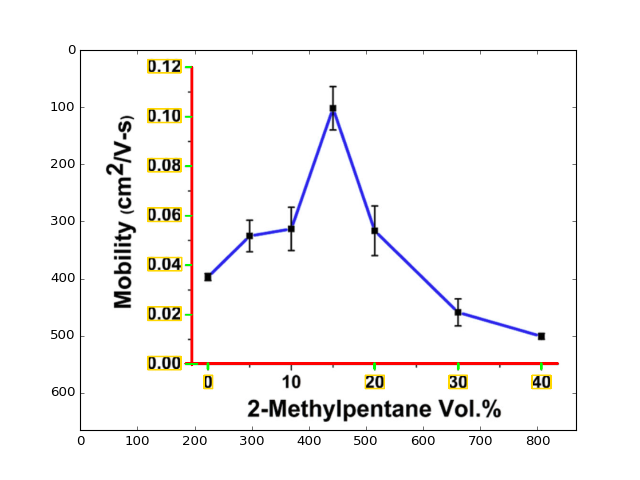

//anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/comm/comm.py:52: DeprecationWarning: Comm._comm_id_default is deprecated: use @default decorator instead.
  def _comm_id_default(self):
//anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/comm/comm.py:29: DeprecationWarning: Comm._iopub_socket_default is deprecated: use @default decorator instead.
  def _iopub_socket_default(self):
//anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/comm/comm.py:24: DeprecationWarning: Comm._kernel_default is deprecated: use @default decorator instead.
  def _kernel_default(self):
//anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/comm/comm.py:32: DeprecationWarning: Comm._session_default is deprecated: use @default decorator instead.
  def _session_default(self):
//anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/comm/comm.py:41: DeprecationWarning: Comm._topic_default is deprecated: use @default decorator instead.
  def _topic_default(self):
//anaconda/envs/py27/

In [33]:
%matplotlib notebook
for x1,y1,x2,y2 in yt_pts:
    cv2.line(imlabel,(x1,y1),(x2,y2),(0,255,0),2)

implot = plt.imshow(imlabel)

In [34]:
yt_pts_array = np.array(yt_pts)
print('y axis pixels')
print(yt_pts_array[:,1].reshape(-1,1))

y axis pixels
[[ 31]
 [118]
 [204]
 [291]
 [377]
 [464]
 [550]]


In [35]:
print('y axis data')
print(yt_label_array[:,0].reshape(-1,1))

y axis data
[[ 0.12]
 [ 0.1 ]
 [ 0.08]
 [ 0.06]
 [ 0.04]
 [ 0.02]
 [ 0.  ]]


## Regress the y tick labels to the y ticks

In [36]:
from sklearn import datasets, linear_model
regry = linear_model.LinearRegression(fit_intercept=True)

regry.fit(yt_pts_array[:,1].reshape(-1,1), yt_label_array[:,0].reshape(-1,1))

# The coefficients
print 'Coefficients: \n', regry.coef_
print 'Intercept: \n', regry.intercept_

Coefficients: 
[[-0.00023121]]
Intercept: 
[ 0.12721704]


## Finally, Extract the Data by Clustering

This is where the problem explodes. This is not a universal approach.

In [38]:
from color_series_scrape import color_series_scrape

pix_pts, ROI = color_series_scrape(example, [[xax[0],xax[2]]],[[yax[3],yax[1]]], n_colors=2)

print('Done clustering')

KM: fitting model on a small sub-sample of the data
done fitting
KM: Prediciting color indiced on the full image
done predicting
KM: recreating clustered image
Done clustering


KM: fitting model on a small sub-sample of the data
done fitting
KM: Prediciting color indiced on the full image
done predicting
KM: recreating clustered image


<IPython.core.display.Javascript object>


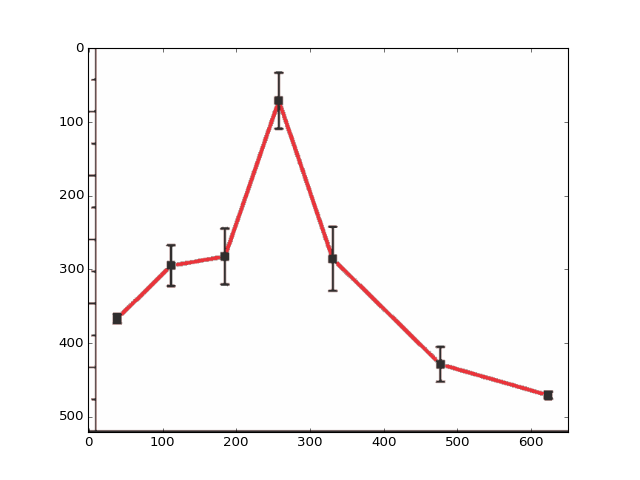

//anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/comm/comm.py:52: DeprecationWarning: Comm._comm_id_default is deprecated: use @default decorator instead.
  def _comm_id_default(self):
//anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/comm/comm.py:29: DeprecationWarning: Comm._iopub_socket_default is deprecated: use @default decorator instead.
  def _iopub_socket_default(self):
//anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/comm/comm.py:24: DeprecationWarning: Comm._kernel_default is deprecated: use @default decorator instead.
  def _kernel_default(self):
//anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/comm/comm.py:32: DeprecationWarning: Comm._session_default is deprecated: use @default decorator instead.
  def _session_default(self):
//anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/comm/comm.py:41: DeprecationWarning: Comm._topic_default is deprecated: use @default decorator instead.
  def _topic_default(self):
//anaconda/envs/py27/

In [39]:
from cluster_data import cluster_colorspace_km, return_series

im_recon, im_label = cluster_colorspace_km(ROI[0], 4)
labels_as_ims = return_series(im_label)

%matplotlib notebook
plt.imshow(im_recon)

<IPython.core.display.Javascript object>


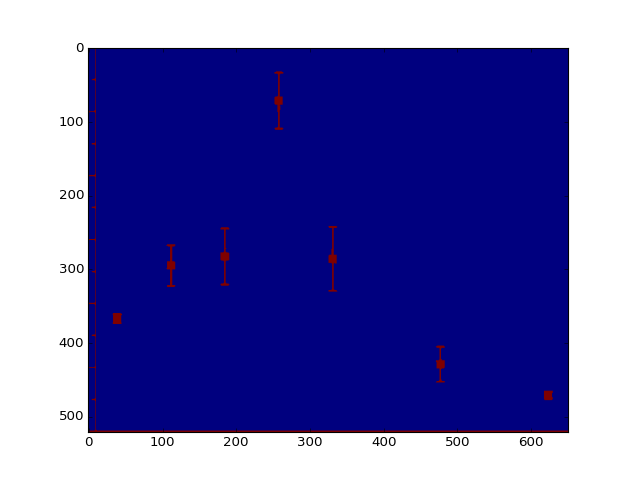

//anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/comm/comm.py:52: DeprecationWarning: Comm._comm_id_default is deprecated: use @default decorator instead.
  def _comm_id_default(self):
//anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/comm/comm.py:29: DeprecationWarning: Comm._iopub_socket_default is deprecated: use @default decorator instead.
  def _iopub_socket_default(self):
//anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/comm/comm.py:24: DeprecationWarning: Comm._kernel_default is deprecated: use @default decorator instead.
  def _kernel_default(self):
//anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/comm/comm.py:32: DeprecationWarning: Comm._session_default is deprecated: use @default decorator instead.
  def _session_default(self):
//anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/comm/comm.py:41: DeprecationWarning: Comm._topic_default is deprecated: use @default decorator instead.
  def _topic_default(self):
//anaconda/envs/py27/

In [40]:
%matplotlib notebook

plt.imshow(labels_as_ims[0])

<IPython.core.display.Javascript object>


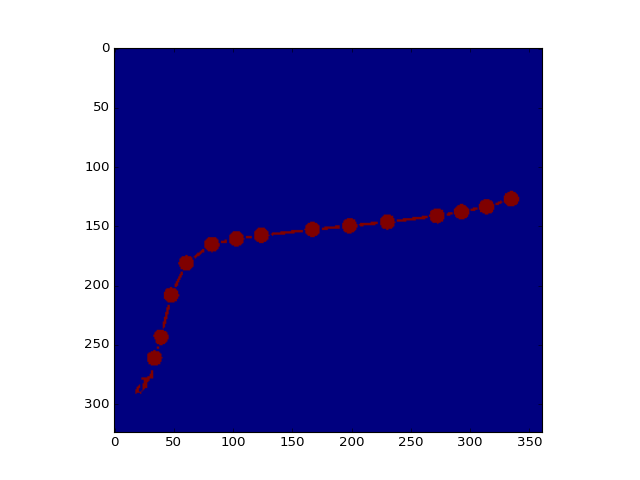

In [116]:
%matplotlib notebook

plt.imshow(labels_as_ims[1])

<IPython.core.display.Javascript object>


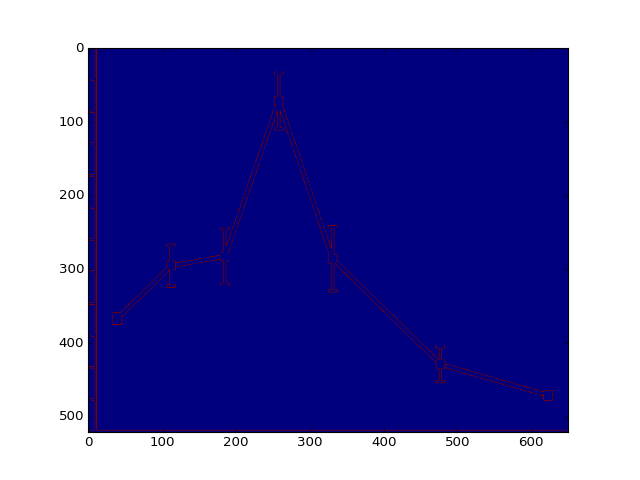

//anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/comm/comm.py:52: DeprecationWarning: Comm._comm_id_default is deprecated: use @default decorator instead.
  def _comm_id_default(self):
//anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/comm/comm.py:29: DeprecationWarning: Comm._iopub_socket_default is deprecated: use @default decorator instead.
  def _iopub_socket_default(self):
//anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/comm/comm.py:24: DeprecationWarning: Comm._kernel_default is deprecated: use @default decorator instead.
  def _kernel_default(self):
//anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/comm/comm.py:32: DeprecationWarning: Comm._session_default is deprecated: use @default decorator instead.
  def _session_default(self):
//anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/comm/comm.py:41: DeprecationWarning: Comm._topic_default is deprecated: use @default decorator instead.
  def _topic_default(self):
//anaconda/envs/py27/

In [41]:
%matplotlib notebook

plt.imshow(labels_as_ims[2])

<IPython.core.display.Javascript object>


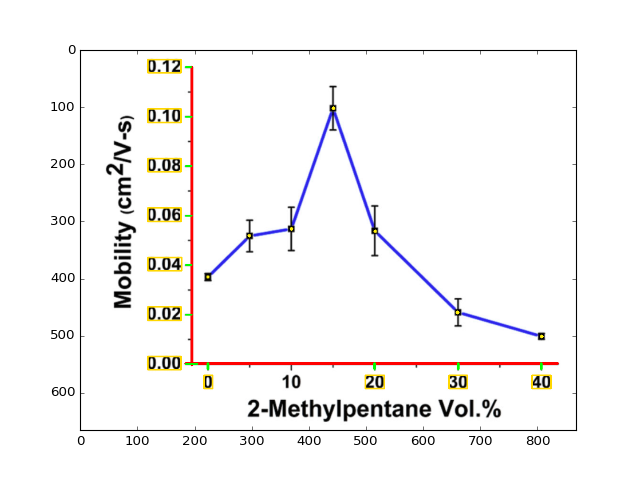

//anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/comm/comm.py:52: DeprecationWarning: Comm._comm_id_default is deprecated: use @default decorator instead.
  def _comm_id_default(self):
//anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/comm/comm.py:29: DeprecationWarning: Comm._iopub_socket_default is deprecated: use @default decorator instead.
  def _iopub_socket_default(self):
//anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/comm/comm.py:24: DeprecationWarning: Comm._kernel_default is deprecated: use @default decorator instead.
  def _kernel_default(self):
//anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/comm/comm.py:32: DeprecationWarning: Comm._session_default is deprecated: use @default decorator instead.
  def _session_default(self):
//anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/comm/comm.py:41: DeprecationWarning: Comm._topic_default is deprecated: use @default decorator instead.
  def _topic_default(self):
//anaconda/envs/py27/

In [42]:
%matplotlib notebook
imlabel4 = imlabel.copy()
pp_list = []
for series in pix_pts[0]:
    s_list = []
    for tup in series:
        x = int(round(tup[1]))+xax[0]
        y = int(round(tup[0]))+yax[3]
        s_list.append([x,y])
    pp_list.append(s_list)

pp_list

for series in pp_list:
    for pt in series:
        cv2.circle(imlabel4,(pt[0],pt[1]), 3, (255,240,10), -1)


lastplot = plt.imshow(imlabel4)

## ... and convert the pixel values to the units of the axes

In [43]:
data_list = []
for series in pp_list:
    ser_list = []
    for pt in series:
        xdata = pt[0]*regrx.coef_+regrx.intercept_
        ydata = pt[1]*regry.coef_+regry.intercept_
        ser_list.append([xdata[0,0],ydata[0,0]])
    data_list.append(ser_list[::-1])

data_list

[[[40.05495039088423, 0.011147911660497903],
  [29.95484194681385, 0.020858874454151466],
  [-0.0019422818574774681, 0.035194105244782919],
  [4.9450496091157703, 0.051841470033903311],
  [20.060858164867355, 0.053691177232694468],
  [10.029457941504941, 0.054616030832090046],
  [15.04515805318615, 0.10340205820020676]]]

In [58]:
[[format(j[0],'.3f'),format(j[1],'.3f')] for j in data_list[0]]

[['40.055', '0.011'],
 ['29.955', '0.021'],
 ['-0.002', '0.035'],
 ['4.945', '0.052'],
 ['20.061', '0.054'],
 ['10.029', '0.055'],
 ['15.045', '0.103']]

## Broader Problem: How to identify Graphs?

In [120]:
spat_stats_path = '/Users/Imperssonator/CC/MIC-Pres/SS PCA presentation/Slide1.tiff'
ss_img = cv2.imread(spat_stats_path)

<IPython.core.display.Javascript object>


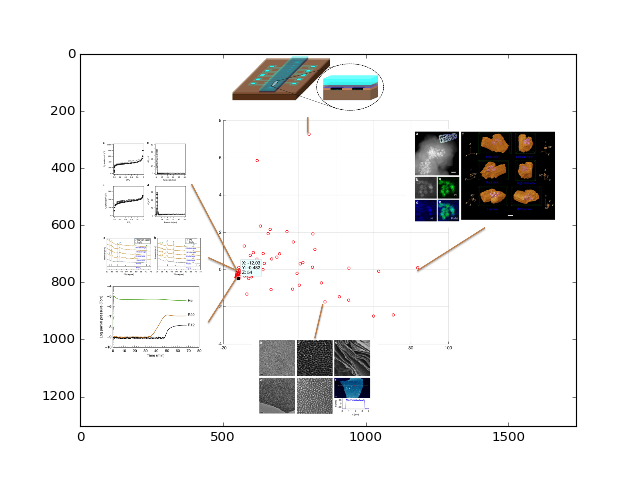

In [121]:
%matplotlib notebook
plt.imshow(ss_img)